In [ ]:
# Ver 2.1
# No pooling
# x: number,fre,time

In [1]:
import tensorflow as tf
import scipy.io as sio
sess = tf.InteractiveSession()
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define functions

def conv2d(x, W, dy ,dx):
  return tf.nn.conv2d(x, W, strides=[1, dx, dy, 1], padding='SAME')

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [112]:
# Define the parameters of the network

#-----------ACC 0.68 *** score 74----------------
nx_conv1=128      # filter_width (fre)
my_conv1=1   # filter_height  (time)
dnx_conv1=128    # stride_width
dmy_conv1=1    # stride_height


channels_conv1=128   # channels num

nx_conv2=1
my_conv2=16
dnx_conv2=1
dmy_conv2=16


channels_conv2=8

size_input_fc1=int(128*128*channels_conv2/dnx_conv1/dmy_conv1/dnx_conv2/dmy_conv2)
num_neurons_fc1=size_input_fc1

print(size_input_fc1)

64


In [5]:
# Read osu! data

dataList=os.listdir('D:/OSU/SongMat/Train/')
inputOsu=np.empty([0,128*128]);
outputOsu=np.empty([0,4]);
for i in range(np.size(dataList)):
    data=sio.loadmat('D:/OSU/SongMat/Train/'+dataList[i])
    inputOsu=np.append(inputOsu,data['input1'].reshape(-1,128*128),axis=0)
    outputOsu=np.append(outputOsu,data['target1'].reshape(-1,4),axis=0)



In [6]:
outputOsu2=np.zeros([outputOsu.shape[0],2]);
outputOsu2[:,0]=outputOsu[:,0]+outputOsu[:,1]+outputOsu[:,2]
outputOsu2[:,1]=outputOsu[:,3]

In [113]:
x = tf.placeholder("float", shape=[None, 128*128])
y_ = tf.placeholder("float", shape=[None, 2])


x_image = tf.reshape(x, [-1,128,128,1])

W_conv1 = weight_variable([nx_conv1,my_conv1,1,channels_conv1])
b_conv1 = bias_variable([channels_conv1])


h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, dnx_conv1, dmy_conv1 ) + b_conv1)


W_conv2 = weight_variable([nx_conv2, my_conv2, channels_conv1, channels_conv2])
b_conv2 = bias_variable([channels_conv2])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, dnx_conv2, dmy_conv2 ) + b_conv2)



W_fc1 = weight_variable([size_input_fc1, num_neurons_fc1])
b_fc1 = bias_variable([num_neurons_fc1])

h_pool2_flat = tf.reshape(h_conv2, [-1, size_input_fc1])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


W_fc2 = weight_variable([num_neurons_fc1, 2])
b_fc2 = bias_variable([2])



keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)



cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


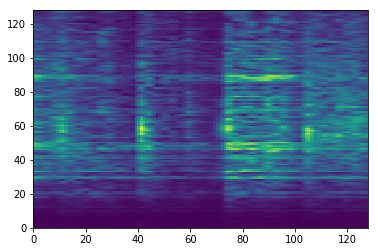

In [128]:
tmp=np.reshape(inputOsu[129,:],[-1,128,128])
plt.pcolor(tmp[0,:,:])
plt.show()

In [12]:
#sess.run(tf.initialize_all_variables())  


In [114]:
sess.run(tf.global_variables_initializer())

In [115]:
saver = tf.train.Saver()


In [116]:
step_size=250
N=inputOsu.shape[0]
print(N)
#shuffle the order
order = np.arange(N-2000)
np.random.shuffle(order)

for n in range(10):
    for i in range(N-2000):
        if i%step_size == 0:
            train_accuracy = accuracy.eval(feed_dict={x: inputOsu[order[i:i+step_size],:], y_: outputOsu2[order[i:i+step_size],:], keep_prob: 1.0})
#             print("step %d, training accuracy %g" %(i, train_accuracy))
            train_step.run(feed_dict={x: inputOsu[order[i:i+step_size],:], y_: outputOsu2[order[i:i+step_size],:], keep_prob: 0.5})

    print("test accuracy %g"%accuracy.eval(feed_dict={x: inputOsu[-1000:,:], y_: outputOsu2[-1000:,:], keep_prob: 1.0}))
    


27051
test accuracy 0.483
test accuracy 0.535
test accuracy 0.589
test accuracy 0.596
test accuracy 0.604
test accuracy 0.641
test accuracy 0.661
test accuracy 0.657
test accuracy 0.666
test accuracy 0.66


In [18]:
save_path = saver.save(sess, "D:/OSU/results/save/",global_step=n)

In [117]:
print(y_conv.eval(feed_dict={x: inputOsu[200:210:1,:], keep_prob: 1.0}))
print ("test accuracy %g"%accuracy.eval(feed_dict={
  x: inputOsu[-500:,:], y_: outputOsu2[-500:,:], keep_prob: 1.0}))

[[ 0.60621792  0.39378214]
 [ 0.63374293  0.36625704]
 [ 0.60956866  0.39043131]
 [ 0.56788677  0.43211317]
 [ 0.57043535  0.42956468]
 [ 0.60929829  0.39070174]
 [ 0.57834399  0.42165604]
 [ 0.56177068  0.43822929]
 [ 0.60200363  0.39799637]
 [ 0.59393364  0.40606639]]
test accuracy 0.63


In [118]:
# Save the output of new maps 

dataList=os.listdir('D:/OSU/SongMat/Create/')
# inputOsuNew=np.empty([0,128*128]);
for i in range(np.size(dataList)):
    if dataList[i][0]!='y' and dataList[i][0]!='y2':
        data=sio.loadmat('D:/OSU/SongMat/Create/'+dataList[i])
        inputOsuNew=data['input'].reshape(-1,128*128)
        if inputOsuNew.shape[0]>1500:
            y_result=y_conv.eval(feed_dict={x: inputOsuNew[:1500,:], keep_prob: 1.0})
        else:
            y_result=y_conv.eval(feed_dict={x: inputOsuNew[:,:], keep_prob: 1.0})
        data_save={'y2':y_result}
        sio.savemat('D:/OSU/SongMat/Create/y2_'+dataList[i],data_save)


In [35]:
y_result

array([[ 0.40739161,  0.10473893,  0.32144737,  0.16642208],
       [ 0.2198986 ,  0.14390311,  0.15379874,  0.48239955],
       [ 0.46475405,  0.24176331,  0.11542311,  0.1780595 ],
       ..., 
       [ 0.0570819 ,  0.05058763,  0.02573004,  0.86660039],
       [ 0.39749449,  0.087804  ,  0.24687061,  0.26783079],
       [ 0.14267607,  0.01611047,  0.08940741,  0.75180602]], dtype=float32)

In [ ]:
data_save={'y':y_result}
sio.savemat('D:/OSU/results/innocence/y_innocence.mat',data_save)

In [ ]:
checkpoint_dir='D:/OSU/results/innocence/save/'
ckpt = tf.train.get_checkpoint_state(checkpoint_dir)  
saver.restore(sess, ckpt.model_checkpoint_path)  

In [ ]:
saver2 = tf.train.Saver()

In [ ]:
checkpoint_dir='/Users/dongqihan/Desktop/FrOstNova/save/'
ckpt = tf.train.get_checkpoint_state(checkpoint_dir)  
saver2.restore(sess, ckpt.model_checkpoint_path)  

In [ ]:
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess_tmp = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess_tmp.run(c))

In [ ]:
data_test=sio.loadmat('/Users/dongqihan/Desktop/FrOstNova/granat.mat')
inputOsu_test=data_test['input'].reshape(-1,128*128)
y_result_test=y_conv.eval(feed_dict={x: inputOsu_test, keep_prob: 1.0})
data={'y':y_result_test}
sio.savemat('/Users/dongqihan/Desktop/FrOstNova/y_memory2granat.mat',data)